Seed 1 Overall Accs: [0.9362499713897704, 0.4583333432674408, 0.3149999976158142]
Seed 1 Acc List: [0.9362499713897704, 0.9662500023841858, 1.0]
Seed 2 Overall Accs: [0.8987500071525574, 0.4677777886390686, 0.3682142794132232]
Seed 2 Acc List: [0.8987500071525574, 0.96875, 0.9990000128746032]
Seed 3 Overall Accs: [0.928749978542328, 0.4777777791023254, 0.3689285814762115]
Seed 3 Acc List: [0.928749978542328, 0.96875, 0.9739999771118164]
Seed 4 Overall Accs: [0.8987500071525574, 0.4772222340106964, 0.3682142794132232]
Seed 4 Acc List: [0.8987500071525574, 0.9674999713897704, 0.9869999885559082]
Seed 5 Overall Accs: [0.9712499976158142, 0.4722222089767456, 0.3667857050895691]
Seed 5 Acc List: [0.9712499976158142, 0.9674999713897704, 1.0]
   Task       AA       AIA   FM        IM  Overall Acc
0     1  0.92675  0.926750  0.0 -0.040750     0.926750
1     2  0.96775  0.947250  0.0 -0.025607     0.470667
2     3  0.99200  0.962167  0.0 -0.075000     0.357429


/tmp/ipykernel_3975677/2371776154.py:91: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.lineplot(data=metrics_mean, x="Task", y=metric, marker="o", palette="tab10")


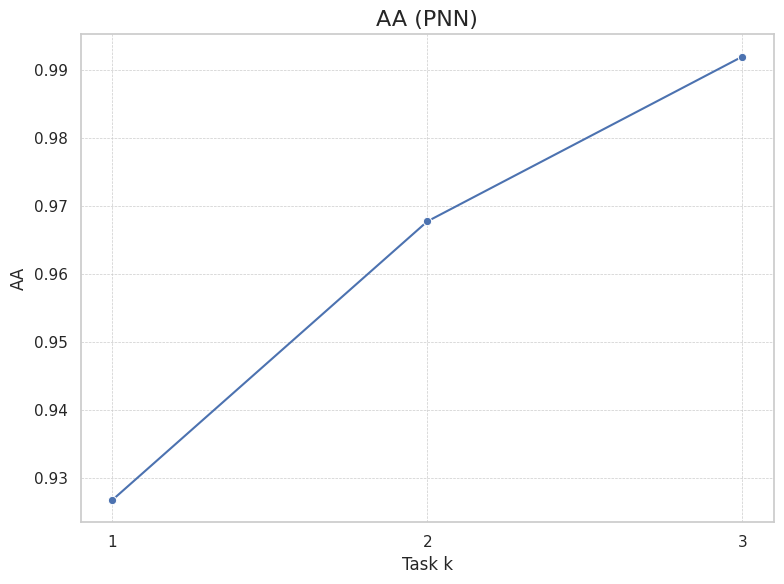

/tmp/ipykernel_3975677/2371776154.py:91: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.lineplot(data=metrics_mean, x="Task", y=metric, marker="o", palette="tab10")


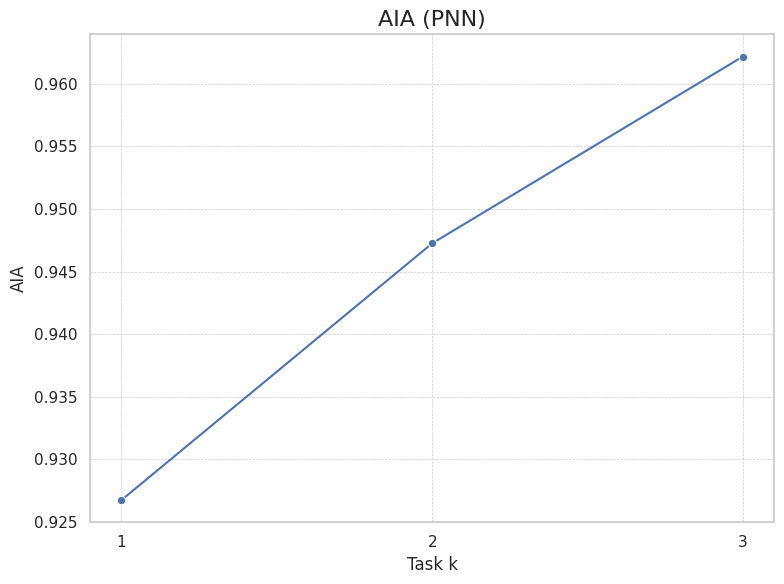

/tmp/ipykernel_3975677/2371776154.py:91: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.lineplot(data=metrics_mean, x="Task", y=metric, marker="o", palette="tab10")


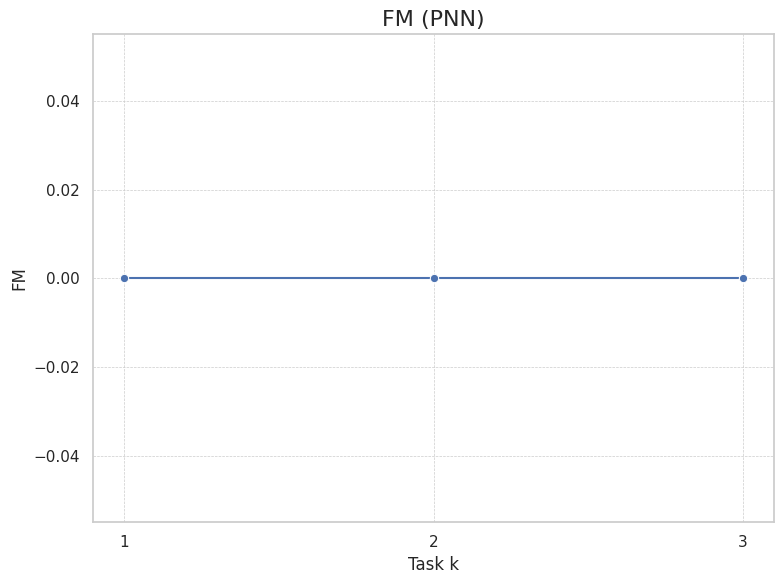

/tmp/ipykernel_3975677/2371776154.py:91: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.lineplot(data=metrics_mean, x="Task", y=metric, marker="o", palette="tab10")


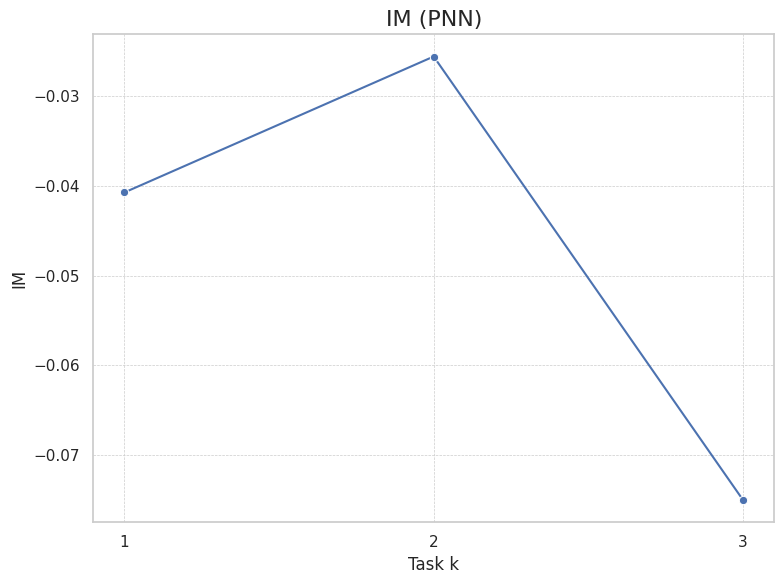

/tmp/ipykernel_3975677/2371776154.py:91: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.lineplot(data=metrics_mean, x="Task", y=metric, marker="o", palette="tab10")


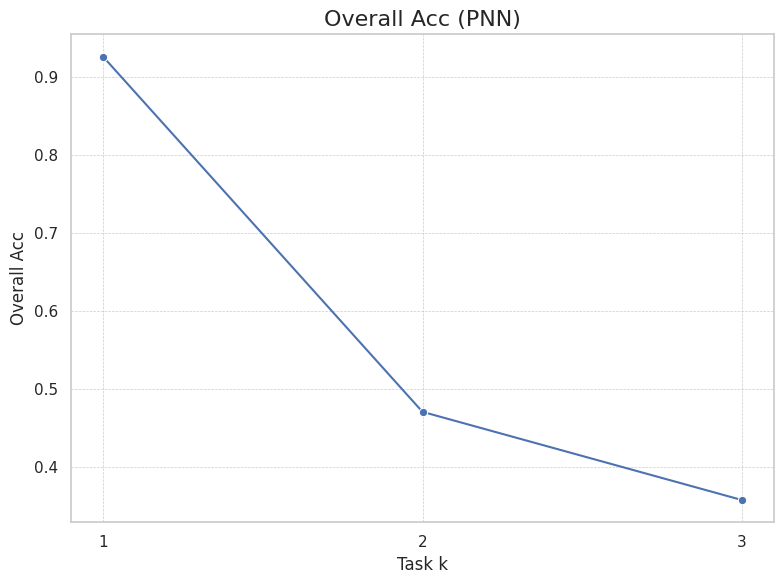

In [16]:
import os
import numpy as np
import pandas as pd

# --- 設定 ---
base_dir = "/work/csv/uci-har/cil_each/pnn"  # PNN CSV の格納ディレクトリ
joint_csv_path = "/work/csv/uci-har/cil-joint/ltc_ncps.csv" # joint CSV
seeds = [1, 2, 3, 4, 5]
num_tasks = 3

# --- 指標関数 ---
def compute_aa_and_aia(acc_list):
    AA_list, AIA_list = [], []
    for k in range(len(acc_list)):
        AA_k = acc_list[k]  # 今回は各タスクの精度そのものをAAとする
        AA_list.append(AA_k)
        AIA_list.append(np.mean(AA_list))  # これまでのAAの平均
    return AA_list, AIA_list

def compute_fm(acc_list):
    # 今回の設計ではFMは原理的に0
    return [0.0]*len(acc_list)

def compute_im(acc_list, joint_accs):
    im_list = []
    for k in range(len(acc_list)):
        if k >= len(joint_accs):
            im_list.append(np.nan)
        else:
            im_list.append(joint_accs[k] - acc_list[k])
    return im_list

all_metrics_per_seed = []

# --- joint baseline の読み込み ---
if not os.path.exists(joint_csv_path):
    raise FileNotFoundError(f"Joint CSV が見つかりません: {joint_csv_path}")
df_joint = pd.read_csv(joint_csv_path)
joint_accs = df_joint["テスト精度 (Test Acc)"].tolist()[:num_tasks]

# --- seed ごとのループ ---
for seed in seeds:
    csv_path = os.path.join(base_dir, f"seed_{seed}.csv")
    if not os.path.exists(csv_path):
        print(f"警告: CSVが存在しません: {csv_path}")
        continue

    df = pd.read_csv(csv_path)

    # --- 2回目 inference を overall として抽出 ---
    overall_accs = df[df["phase_type"]=="inference"]["テスト精度 (Test Acc)"].tolist()
    print(f"Seed {seed} Overall Accs: {overall_accs}")

    # --- 1回目 inference（acc_list） ---
    acc_list = df[df["phase_type"]=="training"]["テスト精度 (Test Acc)"].tolist()
    print(f"Seed {seed} Acc List: {acc_list}")
    if len(acc_list) != num_tasks:
        print(f"警告: Task数と一致しません Seed {seed}")

    # --- 指標計算 ---
    aa_list, aia_list = compute_aa_and_aia(acc_list)
    fm_list = compute_fm(acc_list)
    im_list = compute_im(acc_list, joint_accs)

    # --- seedごとのDataFrame作成 ---
    df_seed = pd.DataFrame({
        "Task": list(range(1, num_tasks+1)),
        "AA": aa_list,
        "AIA": aia_list,
        "FM": fm_list,
        "IM": im_list,
        "Overall Acc": overall_accs
    })
    all_metrics_per_seed.append(df_seed)

# --- シード平均計算 ---
all_metrics_df = pd.concat(all_metrics_per_seed, ignore_index=True)
metrics_mean = all_metrics_df.groupby("Task").mean(numeric_only=True).reset_index()

print(metrics_mean)

# --- 可視化 ---
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")
indicators = ['AA', 'AIA', 'FM', 'IM', 'Overall Acc']

for metric in indicators:
    plt.figure(figsize=(8,6))
    sns.lineplot(data=metrics_mean, x="Task", y=metric, marker="o", palette="tab10")
    plt.title(f"{metric} (PNN)", fontsize=16)
    plt.xlabel("Task k", fontsize=12)
    plt.ylabel(metric, fontsize=12)
    plt.xticks(range(1, num_tasks+1))
    plt.grid(True, linestyle="--", linewidth=0.5)
    plt.tight_layout()
    plt.show()
